# **Autoencoder presentacion intermedia**

# Librerias necesarias


In [3]:
#Librerías
import sys
import time
from os import path
from collections import Counter

import pickle
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Datos

In [4]:
# Función para cargar archivos .pkl
def cargar_datos(ruta_archivo):
    with open(ruta_archivo, 'rb') as archivo:
        datos = pickle.load(archivo)
    return datos

In [5]:
# Están los datos en local o drive?
path_stamp_dataset_21_new = None
# path_stamp_dataset_21_new = 'E:Datos ZTF\stamp_dataset_21_new.pkl'

if path_stamp_dataset_21_new == None: # Sólo aplica si el path de drive coincide

    drive.mount('/content/drive') #Montaje de Google Drive
    path_stamp_dataset_21_new = '/content/drive/MyDrive/Proyecto Inteligencia/Datos ZTF/stamp_dataset_21_new.pkl'

#Cargar datasets
datos_stamp_dataset_21_new = cargar_datos(path_stamp_dataset_21_new)

Mounted at /content/drive


# Carga de datos

In [6]:
def print_keys(data, indent=0):
    for key, value in data.items():
        print(' ' * indent + str(key))
        if isinstance(value, dict):
            print_keys(value, indent + 2)
        elif isinstance(value, (list, tuple)):
            print(' ' * (indent + 2) + f'List/Tuple of length {len(value)}')
        elif hasattr(value, 'shape'):
            print(' ' * (indent + 2) + f'Shape: {value.shape}')
        else:
            print(' ' * (indent + 2) + str(type(value)))

print_keys(datos_stamp_dataset_21_new)

class StampDataset(Dataset):
    def __init__(self, data, split):
        self.images = data[split]['images']
        self.features = data[split]['features']
        self.label = data[split]['class']
        self.split = split

    def __len__(self):
        return len(self.label)

    def __getitem__(self, idx):
        return self.images[idx], self.features[idx], self.label[idx]

train_dataset = StampDataset(datos_stamp_dataset_21_new, 'Train')
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = StampDataset(datos_stamp_dataset_21_new, 'Validation')
val_dataloader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=True)

Train
  images
    Shape: (72710, 21, 21, 3)
  features
    Shape: (72710, 26)
  oid
    Shape: (50594,)
  class
    Shape: (72710,)
Test
  images
    Shape: (500, 21, 21, 3)
  features
    Shape: (500, 26)
  oid
    Shape: (500,)
  class
    Shape: (500,)
Validation
  images
    Shape: (500, 21, 21, 3)
  features
    Shape: (500, 26)
  oid
    Shape: (500,)
  class
    Shape: (500,)


# Autoencoder


In [11]:
class Reshape(nn.Module):
    def __init__(self, *args):
        super().__init__()
        self.shape = args

    def forward(self, x):
        return x.view(self.shape)


class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=1),  # 21x21 -> 18x18
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),  # 18x18 -> 18x18
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 18x18 -> 9x9
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # 9x9 -> 9x9
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 9x9 -> 9x9
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 9x9 -> 4x4
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),  # 4x4 -> 4x4
            nn.ReLU(),
            nn.Flatten(),  # 4x4x64 -> 1024
            nn.Linear(1024, 64),  # 1024 -> 64
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(64, 1024),  # 64 -> 1024
            Reshape(-1, 64, 4, 4),  # Reshape to 64 channels, 4x4
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, padding=1, output_padding=1),  # 4x4 -> 9x9
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),  # 9x9 -> 18x18
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=1, padding=1),  # 18x18 -> 18x18
            nn.ReLU(),
            nn.Upsample(size=(21, 21), mode='bilinear', align_corners=True),  # Upsample from 18x18 -> 21x21
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=1, padding=1),  # 21x21x16 -> 21x21x3
            nn.Sigmoid()  # Final output between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

## Entrenamiento



In [7]:
def show_curves(curves):
    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(curves["val_loss"])) + 1

    ax[0].plot(epochs, curves['val_loss'], label='validation')
    ax[0].plot(epochs, curves['train_loss'], label='training')
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training')
    ax[0].legend()

    ax[1].plot(epochs, curves['val_acc'], label='validation')
    ax[1].plot(epochs, curves['train_acc'], label='training')
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training')
    ax[1].legend()

    plt.show()

In [12]:
# Crear el modelo
model = ConvAutoencoder()

# Mover el modelo a GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definir la función de pérdida (RMSE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Entrenamiento
num_epochs = 15
outputs = []

model.train()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for img, _, _ in train_dataloader:
        img = img.to(device)
        img = img.float().permute(0, 3, 1, 2)

        # Paso hacia adelante: calcular las predicciones
        recon = model(img)

        # Calcular la pérdida (MSE y luego raíz cuadrada para obtener RMSE)
        mse_loss = criterion(recon, img)
        rmse_loss = torch.sqrt(mse_loss)

        # Backpropagación y optimización
        optimizer.zero_grad()
        rmse_loss.backward()
        optimizer.step()

        epoch_loss += rmse_loss.item()

    # Imprimir la pérdida promedio de la época
    avg_loss = epoch_loss / len(train_dataloader)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')

    # Guardar las imágenes originales y reconstruidas para visualizar
    outputs.append((epoch, img, recon))


Epoch [1/15], Loss: 0.0820
Epoch [2/15], Loss: 0.0577
Epoch [3/15], Loss: 0.0543
Epoch [4/15], Loss: 0.0520
Epoch [5/15], Loss: 0.0503
Epoch [6/15], Loss: 0.0495
Epoch [7/15], Loss: 0.0492
Epoch [8/15], Loss: 0.0484
Epoch [9/15], Loss: 0.0481
Epoch [10/15], Loss: 0.0478
Epoch [11/15], Loss: 0.0475
Epoch [12/15], Loss: 0.0472
Epoch [13/15], Loss: 0.0469
Epoch [14/15], Loss: 0.0467
Epoch [15/15], Loss: 0.0464


# Muestra de reconstrucción

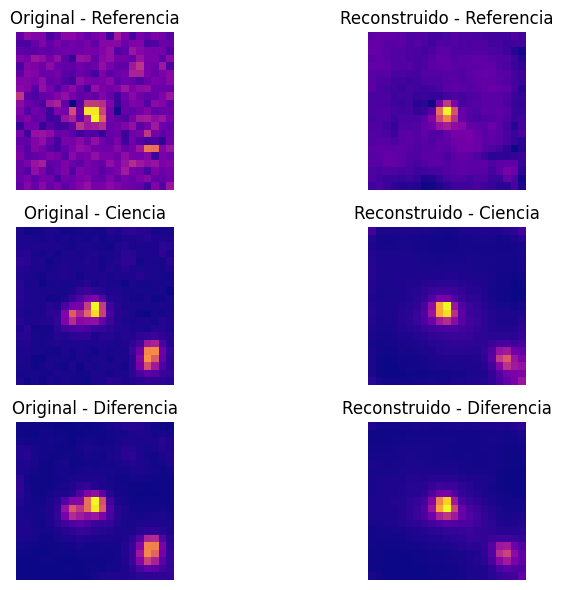

In [15]:
for k in range(12,13):
    plt.figure(figsize=(9, 6))  # Ajustar el tamaño de la figura

    imgs = outputs[k][1].cpu().detach().numpy()  # Imágenes originales
    recon = outputs[k][2].cpu().detach().numpy()  # Imágenes reconstruidas

    # Mostrar la primera imagen original (con sus tres canales)
    for j in range(3):  # Tres canales: Referencia, Ciencia, Diferencia
        plt.subplot(3, 2, 2 * j + 1)
        plt.imshow(imgs[0][j], cmap='plasma')  # Canal j de la imagen 0
        plt.title(f'Original - {["Referencia", "Ciencia", "Diferencia"][j]}')
        plt.axis('off')

    # Mostrar la primera imagen reconstruida (con sus tres canales)
    for j in range(3):  # Tres canales: Referencia, Ciencia, Diferencia
        plt.subplot(3, 2, 2 * j + 2)
        plt.imshow(recon[0][j], cmap='plasma')  # Canal j de la imagen 0
        plt.title(f'Reconstruido - {["Referencia", "Ciencia", "Diferencia"][j]}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()